#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '16pOe_-513PgIDVLbqQN1znTLbBYCKSnE',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

In [ ]:
MY_DATASETS_LINKS = {
    'train_small': '1enj3quiGzgGT_y2kbjeQAKETBkEU6ZwC',
    'train_tiny': '1zKHqhZwsA1apanAmjEAxjptReTM3YGkl',
    'train': '1it3d8vuvpB_7jUQsxJHt6i395PTOV76s',
    'test_small': '17NAF4NKc8ZBy69N6r3I_GAuikju3-qdb',
    'test_tiny': '1uBCol9lBCwIm_T585x-TL1NKqN2WYZKH',
    'test': '1J8gzUaLSBnO1VRYqUPm818mJzA-oAL9v'
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
class Dataset:

    def __init__(self, name, my_drive=False):
        self.name = name
        self.is_loaded = False
        if(my_drive):
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={MY_DATASETS_LINKS[name]}"
        else:
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=16pOe_-513PgIDVLbqQN1znTLbBYCKSnE
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:05<00:00, 19.0MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 3.
Label code corresponds to LYM class.


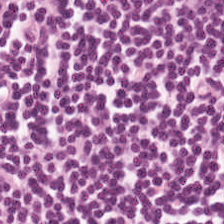

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Загрузка датасетов

In [ ]:
d_test_tiny = Dataset('test_tiny', True)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1uBCol9lBCwIm_T585x-TL1NKqN2WYZKH
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 16.9MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


In [ ]:
d_test_small = Dataset('test_small', True)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=17NAF4NKc8ZBy69N6r3I_GAuikju3-qdb
To: /content/test_small.npz
100%|██████████| 211M/211M [00:06<00:00, 31.9MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [ ]:
d_train_small = Dataset('train_small', True)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1enj3quiGzgGT_y2kbjeQAKETBkEU6ZwC
To: /content/train_small.npz
100%|██████████| 841M/841M [00:16<00:00, 52.2MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


In [ ]:
d_train = Dataset('train', True)
d_test = Dataset('test', True)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1it3d8vuvpB_7jUQsxJHt6i395PTOV76s
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:46<00:00, 45.1MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1J8gzUaLSBnO1VRYqUPm818mJzA-oAL9v
To: /content/test.npz
100%|██████████| 525M/525M [00:15<00:00, 32.9MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [93]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        print(len(gt),len(pred))
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return np.sum([int(i[0] == i[1]) for i in zip(gt, pred)]) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [87]:
input_shape = img.shape

In [101]:
class Model:

    def __init__(self):
     #VGG11
        network = tf.keras.models.Sequential()
        network.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=input_shape,
             kernel_initializer='he_uniform'
             ))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.MaxPooling2D())

        network.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.MaxPooling2D())

        network.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.MaxPooling2D())

        network.add(tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.MaxPooling2D())

        network.add(tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.BatchNormalization())
        network.add(tf.keras.layers.ReLU())
        network.add(tf.keras.layers.MaxPooling2D())

        network.add(tf.keras.layers.Flatten())
        network.add(tf.keras.layers.Dense(512, activation='relu',
                       kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.Dense(4096, activation='relu',
                       kernel_initializer='he_uniform'))
        network.add(tf.keras.layers.Dense(9, activation='softmax',
            kernel_initializer='he_uniform'))

        self.network = network

    def save(self, name: str):
        filename = "/content/drive/MyDrive/" + name + '.h5'
        self.network.save_weights(filename, save_format='h5')

    def load(self, name: str):
    # example demonstrating loading the model with name 'name' from gdrive using link
        name_to_id_dict = {
            'first.h5': '1KZEotWMp0y9cZcPDNCo1kxbgL83Jl0tE',
            'second.h5': '1-4LFSOYNupSOwzYwO8xa4qrJ72FJlG92',
            'best.h5': '1-62bXygfhc9Dfuu5XtcIqHTxev4mBMBT'
        }
        url = f'https://drive.google.com/uc?id={name_to_id_dict[name]}'
        gdown.download(url, quiet=True, output=name, use_cookies=False)
        self.network.load_weights(name)

    def train(self, dataset: Dataset, batch_size, epochs):
        print(f'training started')
        x = dataset.images
        y = dataset.labels
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.network.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
        history = self.network.fit(x, y, batch_size, epochs, #validation_split=0.0, validation_data=None,
                         shuffle=True #validation_steps=None, validation_batch_size=None, validation_freq=1,
        )
        print(f'training done')
        self.history = history
        return history

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction_prob = self.network.predict(img.reshape(1, 224, 224, 3), verbose=0)
        prediction = np.argmax(prediction_prob[0])
        return prediction


---
### Классификация изображений

В качестве валидационной выборки буду использовать tiny_test. Модель обучается на наборе данных train.

#### Вспомогательные функции загрузки и построения графика функции потерь выведены из класса

In [ ]:
def show_loss_per_iter(model, num_iter):
    fig, ax = plt.subplots(1, figsize=(8,6))
    losses = model.history.history['loss']
    num_epochs = len(losses)
    ax.plot(range(num_iter), losses, label="Triplet Loss")
    plt.xlabel("номер эпохи")
    plt.ylabel("Triplet Loss")
    plt.show()

In [ ]:
EVALUATE_ONLY = False

#### Обучение с демонстрацией графиков функции потерь

In [ ]:
model2 = Model()
if not EVALUATE_ONLY:
    history = model2.train(d_train, 100, 20)
    model2.save('first')
else:
    model2.load('best.h5')

training started
Epoch 1/20
180/180 [==============================] - 189s 870ms/step - loss: 3.8412 - accuracy: 0.4296
Epoch 2/20
180/180 [==============================] - 157s 873ms/step - loss: 0.9082 - accuracy: 0.6487
Epoch 3/20
180/180 [==============================] - 157s 873ms/step - loss: 0.8097 - accuracy: 0.7017
Epoch 4/20
180/180 [==============================] - 157s 873ms/step - loss: 0.6572 - accuracy: 0.7651
Epoch 5/20
180/180 [==============================] - 157s 874ms/step - loss: 0.5506 - accuracy: 0.8141
Epoch 6/20
180/180 [==============================] - 157s 874ms/step - loss: 0.4416 - accuracy: 0.8580
Epoch 7/20
180/180 [==============================] - 158s 877ms/step - loss: 0.3856 - accuracy: 0.8776
Epoch 8/20
180/180 [==============================] - 158s 875ms/step - loss: 0.3431 - accuracy: 0.8928
Epoch 9/20
180/180 [==============================] - 158s 876ms/step - loss: 0.2880 - accuracy: 0.9082
Epoch 10/20
180/180 [==========================

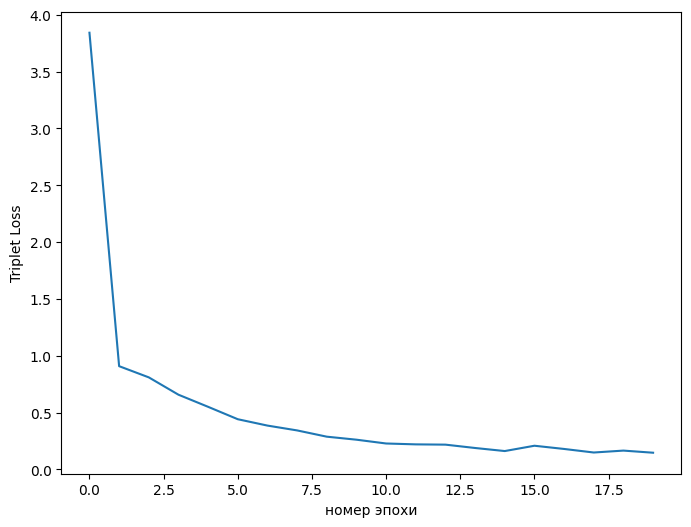

In [ ]:
#LBL1
show_loss_per_iter(model2, 20)

In [89]:
model2 = Model()
model2.load('first.h5')

In [95]:
pred_2 = model2.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred_2, '100% of tiny test')

  0%|          | 0/90 [00:00<?, ?it/s]

metrics for 100% of tiny test:
90 90
	 accuracy 0.3556:
	 balanced accuracy 0.3556:


Модель недообучилась, дообучу модель еще на 20 эпохах.

In [ ]:
model3 = Model()
model3.load('first.h5')
history3 = model3.train(d_train, 100, 20)
model3.save('second')

training started
Epoch 1/20
180/180 [==============================] - 190s 869ms/step - loss: 0.2032 - accuracy: 0.9418
Epoch 2/20
180/180 [==============================] - 156s 865ms/step - loss: 0.2241 - accuracy: 0.9323
Epoch 3/20
180/180 [==============================] - 156s 867ms/step - loss: 0.1932 - accuracy: 0.9420
Epoch 4/20
180/180 [==============================] - 156s 865ms/step - loss: 0.1146 - accuracy: 0.9621
Epoch 5/20
180/180 [==============================] - 156s 868ms/step - loss: 0.1635 - accuracy: 0.9496
Epoch 6/20
180/180 [==============================] - 156s 866ms/step - loss: 0.1304 - accuracy: 0.9559
Epoch 7/20
180/180 [==============================] - 156s 868ms/step - loss: 0.1029 - accuracy: 0.9678
Epoch 8/20
180/180 [==============================] - 156s 866ms/step - loss: 0.0951 - accuracy: 0.9695
Epoch 9/20
180/180 [==============================] - 156s 868ms/step - loss: 0.1359 - accuracy: 0.9576
Epoch 10/20
180/180 [==========================

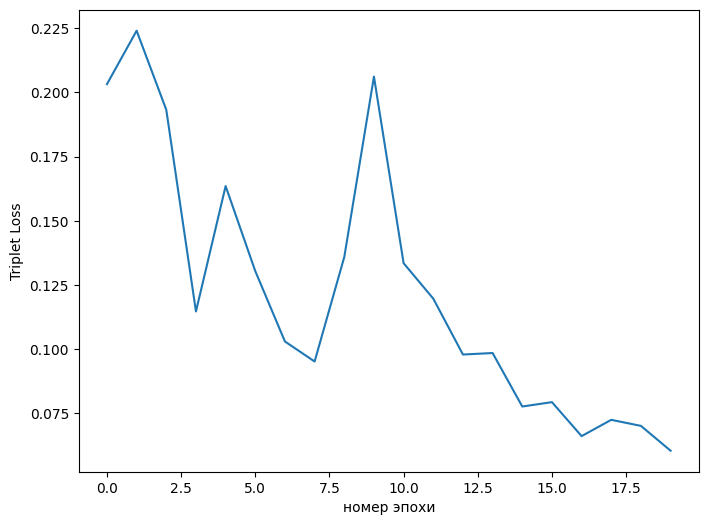

In [ ]:
#LBL2
show_loss_per_iter(model3, 20)

In [96]:
model2.load('second.h5')
pred_3 = model2.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred_3, '100% of tiny test')

  0%|          | 0/90 [00:00<?, ?it/s]

metrics for 100% of tiny test:
90 90
	 accuracy 0.7667:
	 balanced accuracy 0.7667:


Желаемая точность достигнута, но функция потерь еще уменьшается, обучу еще на 20 эпохах.

In [ ]:
model4 = Model()
model4.load('second.h5')
history4 = model4.train(d_train, 100, 20)
model4.save('best')

training started
Epoch 1/20
180/180 [==============================] - 191s 873ms/step - loss: 0.0960 - accuracy: 0.9714
Epoch 2/20
180/180 [==============================] - 156s 869ms/step - loss: 0.1727 - accuracy: 0.9643
Epoch 3/20
180/180 [==============================] - 156s 869ms/step - loss: 0.1219 - accuracy: 0.9674
Epoch 4/20
180/180 [==============================] - 156s 869ms/step - loss: 0.0663 - accuracy: 0.9792
Epoch 5/20
180/180 [==============================] - 156s 869ms/step - loss: 0.0616 - accuracy: 0.9804
Epoch 6/20
180/180 [==============================] - 156s 869ms/step - loss: 0.0556 - accuracy: 0.9827
Epoch 7/20
180/180 [==============================] - 156s 868ms/step - loss: 0.0831 - accuracy: 0.9820
Epoch 8/20
180/180 [==============================] - 157s 870ms/step - loss: 0.0738 - accuracy: 0.9806
Epoch 9/20
180/180 [==============================] - 156s 868ms/step - loss: 0.1060 - accuracy: 0.9677
Epoch 10/20
180/180 [==========================

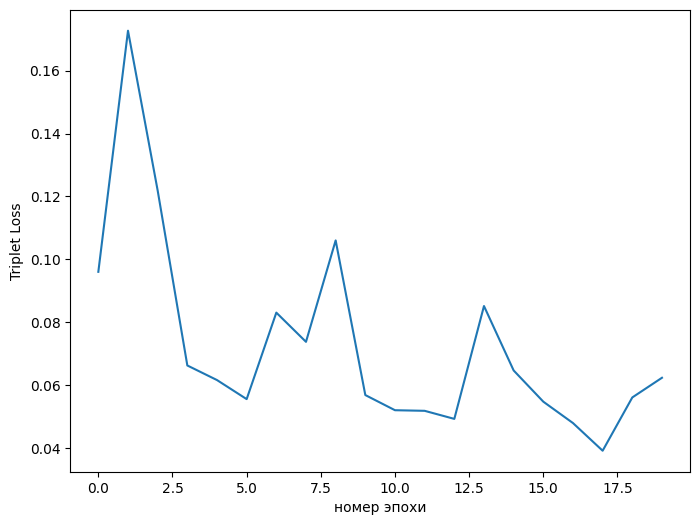

In [ ]:
#LBL3
show_loss_per_iter(model4, 20)

In [97]:
#LBL4
model2.load('best.h5')
pred_3 = model2.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred_3, '100% of tiny test')

  0%|          | 0/90 [00:00<?, ?it/s]

metrics for 100% of tiny test:
90 90
	 accuracy 0.8111:
	 balanced accuracy 0.8111:


Протестирую обученную модель на остальных тестовых наборах данных.

In [ ]:
#LBL5
pred_4 = model2.test_on_dataset(d_test_small)
Metrics.print_all(d_test_small.labels, pred_4, '100% of small test')

  0%|          | 0/1800 [00:00<?, ?it/s]

metrics for 100% of small test:
1800 1800
	 accuracy 0.7911:
	 balanced accuracy 0.7911:


In [41]:
#LBL6
pred_4 = model2.test_on_dataset(d_test)
Metrics.print_all(d_test.labels, pred_4, '100% of full train')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for 100% of full train:
4500 4500
	 accuracy 0.7949:
	 balanced accuracy 0.7949:


Построю матрицу ошибок для набора данных train.

<Axes: >

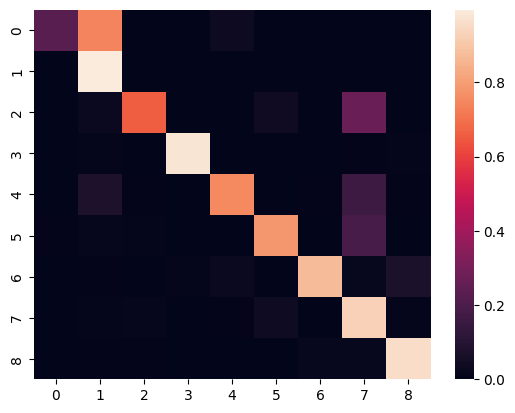

In [62]:
#LBL7
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = pred_4
y_true = d_test.labels
cm = confusion_matrix(y_true, y_pred,normalize='true')
sns.heatmap(cm)

In [63]:
sensivity = np.diag(cm) / np.sum(cm, axis=0)
sum = np.sum(cm)
sum_row = np.sum(cm, axis=0)
sum_col = np.sum(cm, axis=1)
specificity = [(sum - sum_row[j] - sum_col[j] + cm[j][j]) / (sum - sum_col[j]) for j in range(9)]

In [64]:
print(cm)

[[0.226 0.74  0.002 0.    0.032 0.    0.    0.    0.   ]
 [0.    0.996 0.002 0.    0.002 0.    0.    0.    0.   ]
 [0.    0.024 0.66  0.    0.    0.04  0.002 0.272 0.002]
 [0.    0.008 0.    0.978 0.    0.    0.002 0.004 0.008]
 [0.    0.074 0.006 0.    0.754 0.002 0.004 0.156 0.004]
 [0.004 0.014 0.01  0.    0.    0.784 0.    0.188 0.   ]
 [0.    0.004 0.002 0.008 0.026 0.    0.872 0.016 0.072]
 [0.    0.008 0.014 0.    0.004 0.038 0.    0.926 0.01 ]
 [0.    0.006 0.004 0.    0.    0.    0.016 0.016 0.958]]


In [65]:
print(sensivity)

[0.9826087  0.53148346 0.94285714 0.99188641 0.92176039 0.90740741
 0.97321429 0.58681876 0.90891841]


In [66]:
print(specificity)

[0.9994999999999999, 0.89025, 0.9950000000000001, 0.9989999999999999, 0.992, 0.9899999999999999, 0.9969999999999999, 0.9185, 0.988]


**Вывод:** Модель довольно часто путает 0 и 1 класс, выдавая метку "1" для изображений класса "0". Так же происходит и с "7" классом, чью метку часто модель выявляет для изображений "2", "4" и "5" классов.

Визуально 0 и 1 классы оказались не похожи, поэтому сложно оценить, почему модель их путает. В отличии от пар классов 7, 5 и 7, 4, которые имеют схожую текстуру, и ошибки можно считать в какой-то степени схожими с человеческими.

0 класс


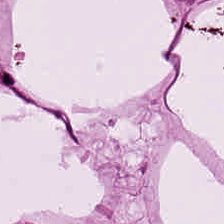

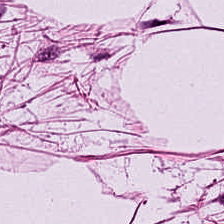

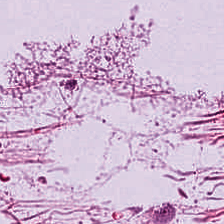

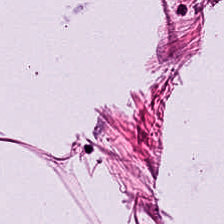

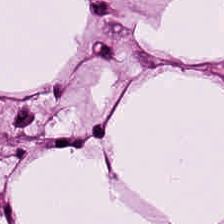

In [71]:
print("0 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 0][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

1 класс


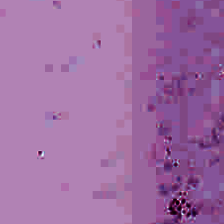

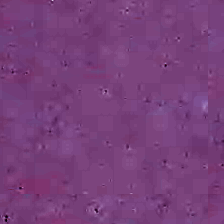

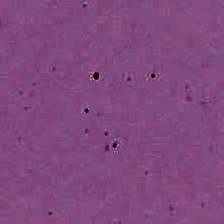

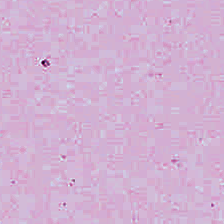

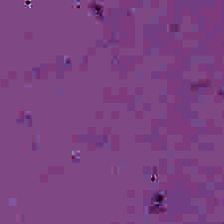

In [72]:
print("1 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 1][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

7 класс


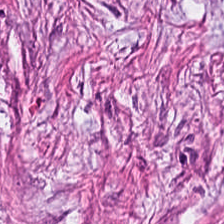

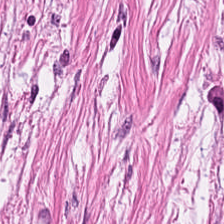

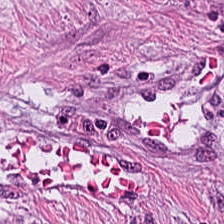

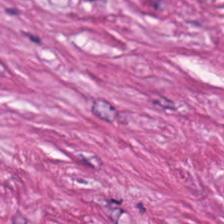

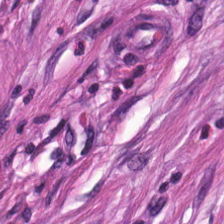

In [73]:
print("7 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 7][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

2 класс


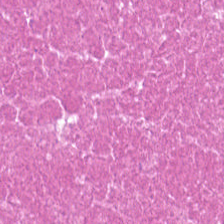

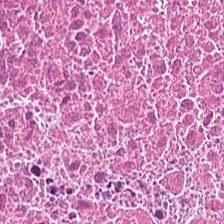

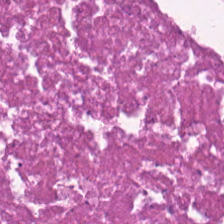

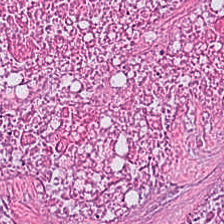

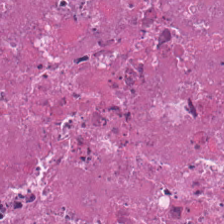

In [76]:
print("2 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 2][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

4 класс


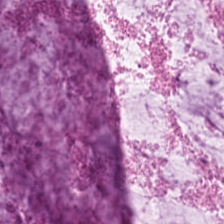

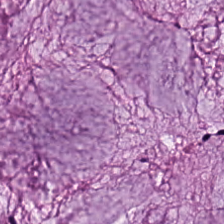

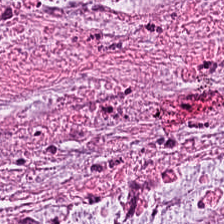

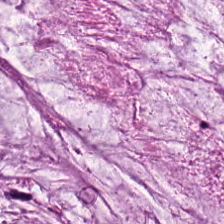

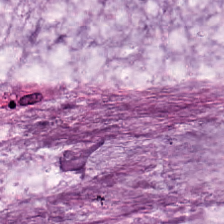

In [79]:
print("4 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 4][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

5 класс


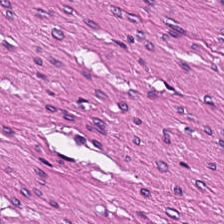

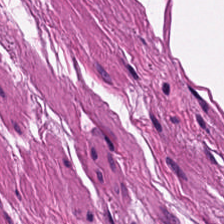

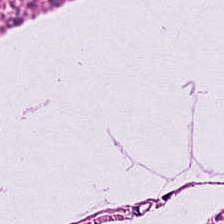

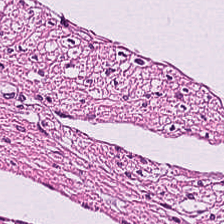

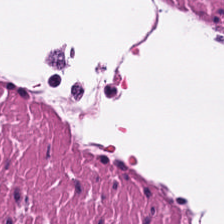

In [78]:
print("5 класс")
for i in range(5):
    img0 = d_train.images[d_train.labels == 5][i]
    pil_img = Image.fromarray(img0)
    IPython.display.display(pil_img)

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [99]:
final_model = Model()
final_model.load('best.h5')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 19.8MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
90 90
	 accuracy 0.8111:
	 balanced accuracy 0.8111:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"